<h1>Worked machine learning examples using SDSS data</h1>

[AstroHackWeek 2014 - J. S. Bloom @profjsb]

See all the materials at: https://github.com/AstroHackWeek/day4
<hr>
Here we'll see some worked ML examples using `scikit-learn` on Sloan Digital Sky Survey Data (SDSS).

It's easiest to grab data from the <a href="http://skyserver.sdss3.org/public/en/tools/search/sql.aspx">SDSS skyserver SQL</a> server.


For example to do a basic query to get two types of photometry (aperature and petrosian), corrected for extinction, for 1000 QSO sources with redshifts:
<font color="blue">
 <pre>SELECT *,dered_u - mag_u AS diff_u, dered_g - mag_g AS diff_g, dered_r - mag_r AS diff_g, dered_i - mag_i AS diff_i, dered_z - mag_z AS diff_z from
(SELECT top 1000
objid, ra, dec, dered_u,dered_g,dered_r,dered_i,dered_z,psfmag_u-extinction_u AS mag_u,
psfmag_g-extinction_g AS mag_g, psfmag_r-extinction_r AS mag_r, psfmag_i-extinction_i AS mag_i,psfmag_z-extinction_z AS mag_z,z AS spec_z,dered_u - dered_g AS u_g_color, 
dered_g - dered_r AS g_r_color,dered_r - dered_i AS r_i_color,dered_i - dered_z AS i_z_color,class
FROM SpecPhoto 
WHERE 
 (class = 'QSO')
 ) as sp
 </pre>
 </font>
Saving this and others like it as a `csv` we can then start to make our data set for classification/regression.

In [61]:
## get the data locally ... I put this on a gist
!curl -k -O https://gist.githubusercontent.com/anonymous/53781fe86383c435ff10/raw/4cc80a638e8e083775caec3005ae2feaf92b8d5b/qso10000.csv
!curl -k -O https://gist.githubusercontent.com/anonymous/2984cf01a2485afd2c3e/raw/964d4f52c989428628d42eb6faad5e212e79b665/star1000.csv
!curl -k -O https://gist.githubusercontent.com/anonymous/2984cf01a2485afd2c3e/raw/335cd1953e72f6c7cafa9ebb81b43c47cb757a9d/galaxy1000.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2378k    0 2378k    0     0   235k      0 --:--:--  0:00:10 --:--:--  311k


In [1]:
# For pretty plotting
!pip install --upgrade seaborn

Requirement already up-to-date: seaborn in /Users/jbloom/anaconda/lib/python2.7/site-packages
Cleaning up...


In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
%pylab inline
import seaborn as sns
sns.set()
import copy

Populating the interactive namespace from numpy and matplotlib


In [3]:
pd.read_csv("qso10000.csv",index_col=0).head()

,ra,dec,dered_u,dered_g,dered_r,dered_i,dered_z,mag_u,mag_g,mag_r,mag_i,mag_z,spec_z,u_g_color,g_r_color,r_i_color,i_z_color,class,diff_u,diff_g,diff_g1,diff_i,diff_z
objid,,,,,,,,,,,,,,,,,,,,,,,
1237648720142532813,146.90229,-0.984913,19.64289,19.31131,19.25328,19.15353,19.13345,19.71604,19.37595,19.32818,19.24847,19.21259,0.652417,0.331583,0.058027,0.099751,0.020077,QSO,-0.073151,-0.064648,-0.074903,-0.094942,-0.079136
1237658425156829371,142.45853,6.646406,19.39569,19.34811,19.16626,18.93152,19.06013,19.40327,19.36566,19.18335,18.94222,19.08077,1.537123,0.047575,0.181847,0.234743,-0.128612,QSO,-0.007589,-0.017550,-0.017090,-0.010700,-0.020636
1237660413189095710,143.15770,8.175363,19.10362,18.88904,18.70672,18.58508,18.61328,19.11102,18.88857,18.70458,18.57886,18.62583,1.467101,0.214582,0.182318,0.121645,-0.028202,QSO,-0.007397,0.000473,0.002148,0.006218,-0.012548
1237660412651962520,142.49264,7.800945,19.88820,19.75146,19.52941,19.65000,19.52470,19.88709,19.75292,19.53512,19.67052,19.50256,1.014217,0.136745,0.222052,-0.120590,0.125301,QSO,0.001118,-0.001457,-0.005716,-0.020527,0.022139
1237658493336944662,142.64367,7.917698,18.45897,18.40651,18.15901,17.77130,17.75986,18.55725,18.55002,18.40316,18.01008,18.03100,0.215603,0.052462,0.247498,0.387709,0.011444,QSO,-0.098282,-0.143515,-0.244150,-0.238779,-0.271137


Notice that there are several things about this dataset. First, RA and DEC are probably not something we want to use in making predictions: it's the location of the object on the sky. Second, the magnitudes are highly covariant with the colors. So dumping all but one of the magnitudes might be a good idea to avoid overfitting. 

In [4]:
qsos = pd.read_csv("qso10000.csv",index_col=0,usecols=["objid","dered_r","spec_z","u_g_color",\
                                                "g_r_color","r_i_color","i_z_color","diff_u",\
                                                "diff_g1","diff_i","diff_z"])

qso_features = copy.copy(qsos)
qso_redshifts = qsos["spec_z"]
del qso_features["spec_z"]
qso_features.head()

,dered_r,u_g_color,g_r_color,r_i_color,i_z_color,diff_u,diff_g1,diff_i,diff_z
objid,,,,,,,,,
1237648720142532813,19.25328,0.331583,0.058027,0.099751,0.020077,-0.073151,-0.074903,-0.094942,-0.079136
1237658425156829371,19.16626,0.047575,0.181847,0.234743,-0.128612,-0.007589,-0.017090,-0.010700,-0.020636
1237660413189095710,18.70672,0.214582,0.182318,0.121645,-0.028202,-0.007397,0.002148,0.006218,-0.012548
1237660412651962520,19.52941,0.136745,0.222052,-0.120590,0.125301,0.001118,-0.005716,-0.020527,0.022139
1237658493336944662,18.15901,0.052462,0.247498,0.387709,0.011444,-0.098282,-0.244150,-0.238779,-0.271137


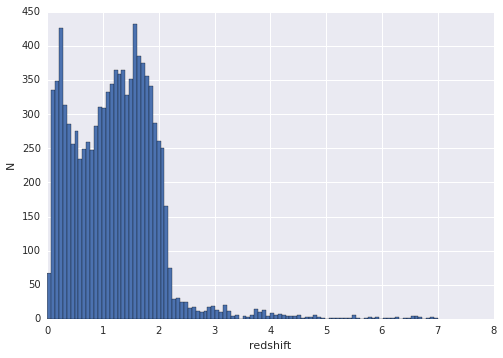

In [5]:
bins =  hist(qso_redshifts.values,bins=100) ; xlabel("redshift") ; ylabel("N")

Pretty clearly a big cut at around $z=2$.

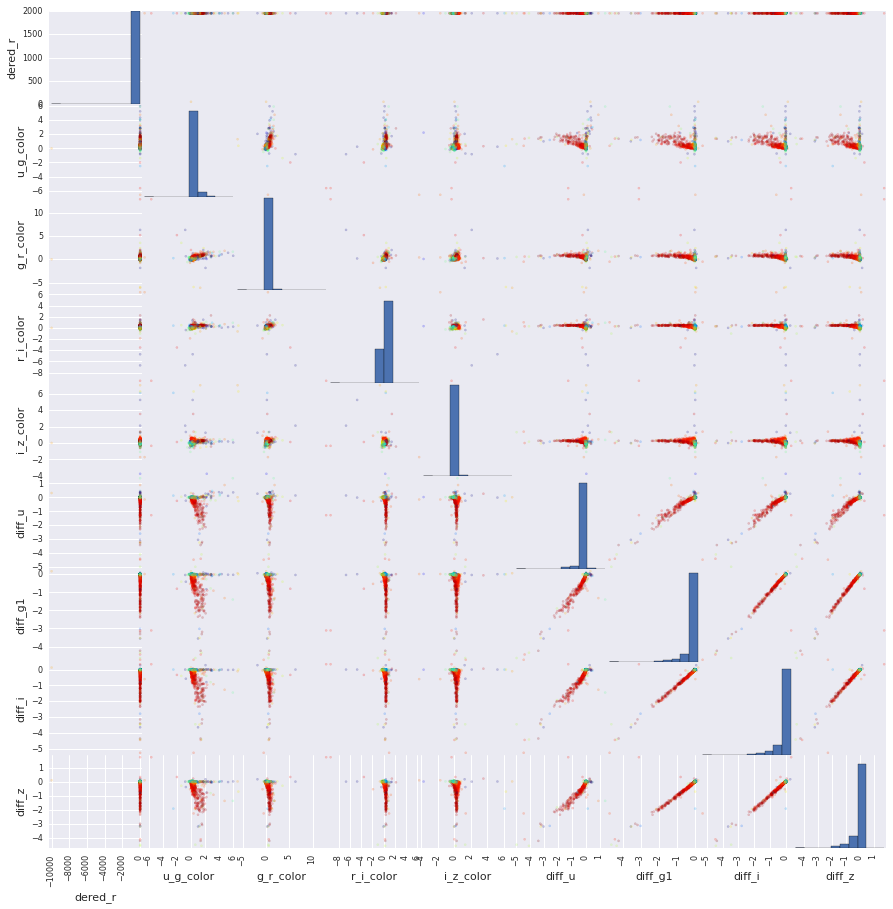

In [6]:
import matplotlib as mpl
import matplotlib.cm as cm
## truncate the color at z=2.5 just to keep some contrast.
norm = mpl.colors.Normalize(vmin=min(qso_redshifts.values), vmax=2.5)
cmap = cm.jet_r
#x = 0.3
m = cm.ScalarMappable(norm=norm, cmap=cmap)
rez = pd.scatter_matrix(qso_features[0:2000], alpha=0.2,figsize=[15,15],color=m.to_rgba(qso_redshifts.values))

Egad. Some pretty crazy values for `dered_r` and `g_r_color`. Let's figure out why.

In [7]:
min(qso_features["dered_r"].values)

-9999.0

Looks like there are some missing values in the catalog which are set at -9999. Let's zoink those from the dataset for now.

In [8]:
qsos = pd.read_csv("qso10000.csv",index_col=0,usecols=["objid","dered_r","spec_z","u_g_color",\
                                                "g_r_color","r_i_color","i_z_color","diff_u",\
                                                "diff_g1","diff_i","diff_z"])

qsos = qsos[(qsos["dered_r"] > -9999) & (qsos["g_r_color"] > -10) & (qsos["g_r_color"] < 10)]
qso_features = copy.copy(qsos)
qso_redshifts = qsos["spec_z"]
del qso_features["spec_z"]

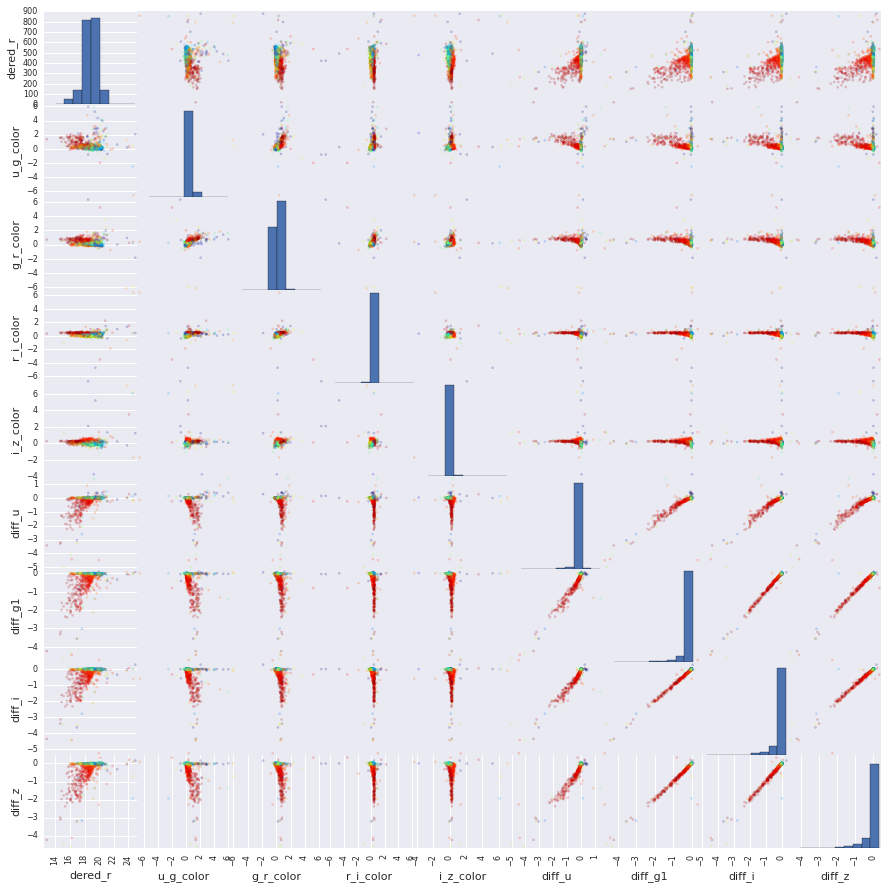

In [9]:
rez = pd.scatter_matrix(qso_features[0:2000], alpha=0.2,figsize=[15,15],\
                        color=m.to_rgba(qso_redshifts.values))

Ok. This looks pretty clean. Let's save this for future use.

In [10]:
qsos.to_csv("qsos.clean.csv")

## Data Munging done. Let's do some ML!

### Basic Model Fitting

We need to create a **training set** and a **testing set**.

In [11]:
X = qso_features.values  # 9-d feature space
Y = qso_redshifts.values # redshifts

In [12]:
print "feature vector shape=", X.shape
print "class shape=", Y.shape

feature vector shape= (9988, 9)
class shape= (9988,)


In [17]:
# half of data
half = floor(len(Y)/2)
train_X = X[:half]
train_Y = Y[:half]
test_X = X[half:]
test_Y = Y[half:]

** Linear Regression **

http://scikit-learn.org/stable/modules/linear_model.html

In [18]:
from sklearn import linear_model
clf = linear_model.LinearRegression()

In [19]:
# fit the model
clf.fit(train_X, train_Y)

LinearRegression(copy_X=True, fit_intercept=True, normalize=False)

In [20]:
# now do the prediction
Y_lr_pred = clf.predict(test_X)

# how well did we do?
from sklearn.metrics import mean_squared_error
mse = np.sqrt(mean_squared_error(test_Y,Y_lr_pred)) ; print "MSE",mse

MSE 0.659053404786


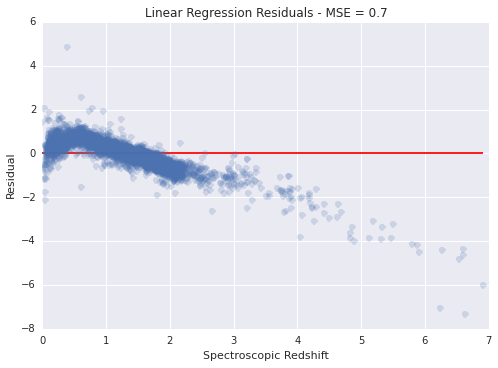

In [21]:
plot(test_Y,Y_lr_pred - test_Y,'o',alpha=0.2)
title("Linear Regression Residuals - MSE = %.1f" % mse)
xlabel("Spectroscopic Redshift")
ylabel("Residual")
hlines(0,min(test_Y),max(test_Y),color="red")

In [22]:
# here's the MSE guessing the AVERAGE value
print "naive mse", ((1./len(train_Y))*(train_Y - train_Y.mean())**2).sum()

naive mse 0.643120844956


In [23]:
mean_squared_error?

** *k*-Nearest Neighbor (KNN) Regression **

In [24]:
from sklearn import neighbors
from sklearn import preprocessing
X_scaled = preprocessing.scale(X) # many methods work better on scaled X
clf1 = neighbors.KNeighborsRegressor(5)
train_X = X_scaled[:half]
test_X = X_scaled[half:]
clf1.fit(train_X,train_Y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_neighbors=5, p=2, weights='uniform')

MSE (KNN) 0.239666881833


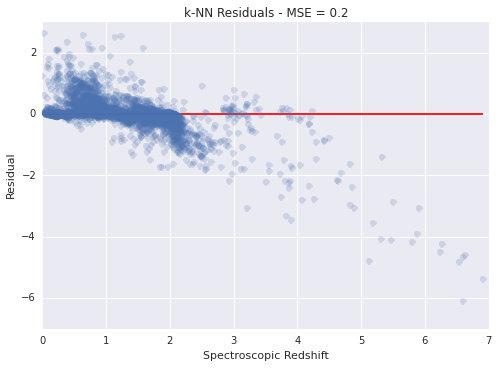

In [25]:
Y_knn_pred = clf1.predict(test_X)
mse = mean_squared_error(test_Y,Y_knn_pred) ; print "MSE (KNN)", mse
plot(test_Y, Y_knn_pred - test_Y,'o',alpha=0.2)
title("k-NN Residuals - MSE = %.1f" % mse)
xlabel("Spectroscopic Redshift")
ylabel("Residual")
hlines(0,min(test_Y),max(test_Y),color="red")

In [26]:
from sklearn import neighbors
from sklearn import preprocessing

X_scaled = preprocessing.scale(X) # many methods work better on scaled X
train_X = X_scaled[:half]
train_Y = Y[:half]
test_X = X_scaled[half:]
test_Y = Y[half:]
clf1 = neighbors.KNeighborsRegressor(10)
clf1.fit(train_X,train_Y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_neighbors=10, p=2, weights='uniform')

0.234493621244


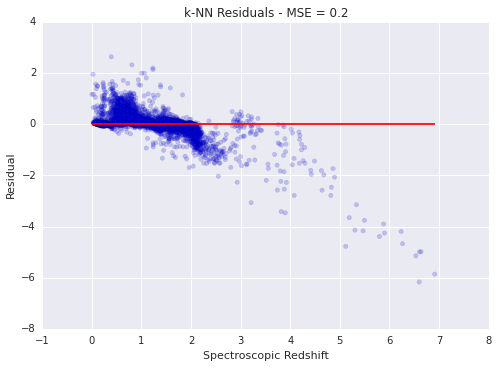

In [98]:
Y_knn_pred = clf1.predict(test_X)
mse = mean_squared_error(test_Y,Y_knn_pred) ; print mse
scatter(test_Y, Y_knn_pred - test_Y,alpha=0.2)
title("k-NN Residuals - MSE = %.1f" % mse)
xlabel("Spectroscopic Redshift")
ylabel("Residual")
hlines(0,min(test_Y),max(test_Y),color="red")

#### Random Forests
Pretty good intro
http://blog.yhathq.com/posts/random-forests-in-python.html

In [31]:
from sklearn.ensemble import RandomForestRegressor
clf2 = RandomForestRegressor(n_estimators=100, 
                            criterion='mse', max_depth=None, 
                            min_samples_split=2, min_samples_leaf=1, 
                            max_features='auto', max_leaf_nodes=None, 
                            bootstrap=True, oob_score=False, n_jobs=1, 
                            random_state=None, verbose=0, 
                            min_density=None, compute_importances=None)
clf2.fit(train_X,train_Y)

RandomForestRegressor(bootstrap=True, compute_importances=None,
           criterion='mse', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
           min_samples_split=2, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0)

0.202398294159


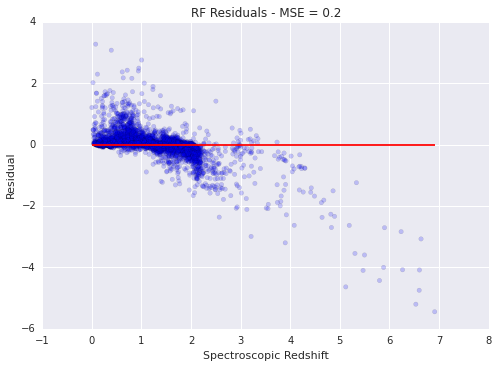

In [32]:
Y_rf_pred = clf2.predict(test_X)
mse = mean_squared_error(test_Y,Y_rf_pred) ; print mse
scatter(test_Y, Y_rf_pred - test_Y,alpha=0.2)
title("RF Residuals - MSE = %.1f" % mse)
xlabel("Spectroscopic Redshift")
ylabel("Residual")
hlines(0,min(test_Y),max(test_Y),color="red")

## model selection: cross-validation

In [33]:
from sklearn import cross_validation

In [34]:
from sklearn import linear_model
clf = linear_model.LinearRegression()
from sklearn.cross_validation import cross_val_score

def print_cv_score_summary(model, xx, yy, cv):
    scores = cross_val_score(model, xx, yy, cv=cv, n_jobs=1)
    print("mean: {:3f}, stdev: {:3f}".format(
        np.mean(scores), np.std(scores)))

In [35]:
print_cv_score_summary(clf,X,Y,cv=cross_validation.KFold(len(Y), 5))

mean: 0.237593, stdev: 0.026459


In [36]:
print_cv_score_summary(clf,X,Y,
    cv=cross_validation.KFold(len(Y),10,shuffle=True,random_state=1))

mean: 0.246604, stdev: 0.041721


In [39]:
print_cv_score_summary(clf2,X,Y,
    cv=cross_validation.KFold(len(Y),10,shuffle=True,random_state=1))

mean: 0.607408, stdev: 0.040491


## Classification

Let's do a 3-class classification problem: star, galaxy, or QSO

In [12]:
all_sources = pd.read_csv("qso10000.csv",index_col=0,usecols=["objid","dered_r","u_g_color",\
                                                "g_r_color","r_i_color","i_z_color","diff_u",\
                                                "diff_g1","diff_i","diff_z","class"])[:1000]

all_sources = all_sources.append(pd.read_csv("star1000.csv",index_col=0,usecols=["objid","dered_r","u_g_color",\
                                                "g_r_color","r_i_color","i_z_color","diff_u",\
                                                "diff_g1","diff_i","diff_z","class"]))

all_sources = all_sources.append(pd.read_csv("galaxy1000.csv",index_col=0,usecols=["objid","dered_r","u_g_color",\
                                                "g_r_color","r_i_color","i_z_color","diff_u",\
                                                "diff_g1","diff_i","diff_z","class"]))

all_sources = all_sources[(all_sources["dered_r"] > -9999) & (all_sources["g_r_color"] > -10) & (all_sources["g_r_color"] < 10)]
all_features = copy.copy(all_sources)
all_label = all_sources["class"]
del all_features["class"]
X = copy.copy(all_features.values)
Y = copy.copy(all_label.values)

In [3]:
all_sources.tail()

,dered_r,u_g_color,g_r_color,r_i_color,i_z_color,diff_u,diff_g1,diff_i,diff_z
objid,,,,,,,,,
1237657775542632759,15.42325,1.999353,0.970126,0.435975,0.373470,-1.944487,-1.971534,-2.052320,-1.971382
1237657775542698090,17.51366,2.212025,0.965242,0.410664,0.371384,-0.778788,-0.944075,-0.895832,-0.830559
1237657775542698177,17.15747,1.190033,0.332136,0.252352,0.070980,-2.391565,-2.977261,-2.889906,-2.671612
1237657630586634463,17.19312,1.179663,0.678915,0.394419,0.272171,-1.563450,-1.913368,-1.791895,-1.615683
1237657630049698007,17.20485,1.925320,1.126934,0.477961,0.334377,-1.211906,-1.377165,-1.402037,-1.218332


In [4]:
print "feature vector shape=", X.shape
print "class shape=", Y.shape

feature vector shape= (3000, 9)
class shape= (3000,)


In [5]:
Y[Y=="QSO"] = 0
Y[Y=="STAR"] = 1
Y[Y=="GALAXY"] = 2

Let's look at random forest

In [46]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=200,oob_score=True)
clf.fit(X,Y)

RandomForestClassifier(bootstrap=True, compute_importances=None,
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
            min_samples_split=2, n_estimators=200, n_jobs=1,
            oob_score=True, random_state=None, verbose=0)

what are the important features in the data?

In [47]:
sorted(zip(all_sources.columns.values,clf.feature_importances_),key=lambda q: q[1],reverse=True)

[('u_g_color', 0.24621379942513427),
 ('diff_g1', 0.17095210500690095),
 ('diff_i', 0.13073539972463408),
 ('diff_z', 0.12105441185550342),
 ('g_r_color', 0.094758188792464337),
 ('diff_u', 0.089870190147766496),
 ('r_i_color', 0.062334477766268478),
 ('dered_r', 0.052595128912769143),
 ('i_z_color', 0.03148629836855911)]

In [49]:
clf.oob_score_  ## "Out of Bag" Error

0.95433333333333337

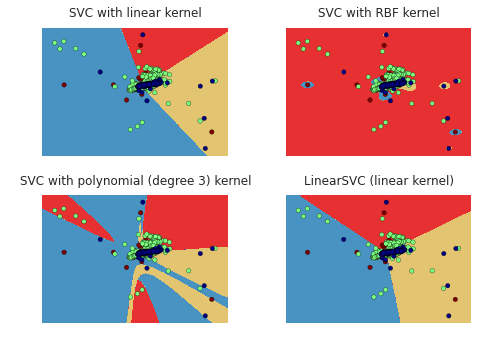

In [7]:
import numpy as np
from sklearn import svm, datasets
cmap = cm.jet_r

# import some data to play with

X = all_features.values[:, 1:3] # use only two features for training and plotting purposes

h = .02  # step size in the mesh

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
svc = svm.SVC(kernel='linear', C=C).fit(X, Y)
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(X, Y)
poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X, Y)
lin_svc = svm.LinearSVC(C=C).fit(X, Y)

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
titles = ['SVC with linear kernel',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel',
          'LinearSVC (linear kernel)']


norm = mpl.colors.Normalize(vmin=min(Y), vmax=max(Y))
m = cm.ScalarMappable(norm=norm, cmap=cmap)

for i, clf in enumerate((svc, rbf_svc, poly_svc, lin_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    subplot(2, 2, i + 1)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    contourf(xx, yy, Z,cmap=cm.Paired)
    axis('off')

    # Plot also the training points
    scatter(X[:, 0], X[:, 1], c=m.to_rgba(Y),cmap=cm.Paired)

    title(titles[i])

## model improvement with GridSearchCV
Hyperparameter optimization

In [16]:
# fit a support vector machine classifier
from sklearn import grid_search
from sklearn import svm
from sklearn import metrics
import logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

# instantiate the SVM object
sdss_svm = svm.SVC()

X = all_features.values
Y = all_label.values

# parameter values over which we will search
parameters = {'kernel':('linear', 'rbf'), \
              'gamma':[0.5, 0.3, 0.1,  0.01],
              'C':[0.1, 2, 4, 5, 10, 20,30]}
#parameters = {'kernel':('linear', 'rbf')}

# do a grid search to find the highest 3-fold CV zero-one score
svm_tune = grid_search.GridSearchCV(sdss_svm, parameters, score_func=metrics.accuracy_score,\
                                    n_jobs = -1, cv = 3,verbose=1)
svm_opt = svm_tune.fit(X, Y)

# print the best score and estimator
print(svm_opt.best_score_)
print(svm_opt.best_estimator_)

Fitting 3 folds for each of 56 candidates, totalling 168 fits


/Users/jbloom/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:347: DeprecationWarning: Passing function as ``score_func`` is deprecated and will be removed in 0.15. Either use strings or score objects. The relevant new parameter is called ''scoring''.
  score_func=self.score_func)
[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 jobs       | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:    9.4s finished


0.955
SVC(C=20, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.1,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


[[231   1   1]
 [  7 254  19]
 [  3   9 225]]


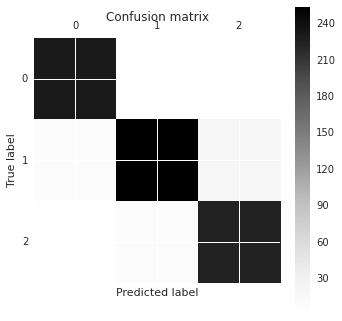

In [31]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0)

classifier = svm.SVC(**svm_opt.best_estimator_.get_params())
y_pred = classifier.fit(X_train, y_train).predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

print(cm)

# Show confusion matrix in a separate window
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [59]:
# instantiate the SVM object
sdss_rf = RandomForestClassifier()

X = all_features.values
Y = all_label.values

# parameter values over which we will search
parameters = {'n_estimators':(10,50,200),"max_features": ["auto",3,5],
              'criterion':["gini","entropy"],"min_samples_leaf": [1,2]}
#parameters = {'kernel':('linear', 'rbf')}

# do a grid search to find the highest 3-fold CV zero-one score
rf_tune = grid_search.GridSearchCV(sdss_rf, parameters, score_func=metrics.accuracy_score,\
                                    n_jobs = -1, cv = 3,verbose=1)
rf_opt = rf_tune.fit(X, Y)

# print the best score and estimator
print(rf_opt.best_score_)
print(rf_opt.best_estimator_)


Fitting 3 folds for each of 36 candidates, totalling 108 fits


/Users/jbloom/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:776: DeprecationWarning: Setting compute_importances is no longer required as version 0.14. Variable importances are now computed on the fly when accessing the feature_importances_ attribute. This parameter will be removed in 0.16.
  DeprecationWarning)
/Users/jbloom/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:347: DeprecationWarning: Passing function as ``score_func`` is deprecated and will be removed in 0.15. Either use strings or score objects. The relevant new parameter is called ''scoring''.
  score_func=self.score_func)
[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 jobs       | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:   21.5s finished
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0

0.949666666667
RandomForestClassifier(bootstrap=True, compute_importances=None,
            criterion='gini', max_depth=None, max_features=3,
            max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
            min_samples_split=2, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=1)


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=1)]: 

In [50]:
clf.get_params()

{'bootstrap': True,
 'compute_importances': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_density': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200,
 'n_jobs': 1,
 'oob_score': True,
 'random_state': None,
 'verbose': 0}

In [19]:
svm_opt.best_estimator_.get_params()

{'C': 20,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'degree': 3,
 'gamma': 0.1,
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [57]:
grid_search.GridSearchCV?